#### COSC2789 -Practical Data Science Assignment 3: Group Project
# STARBUCKS OFFER PERSONALIZATION



#### Group:
#### Group member: 
* Tran Minh Quang - s3757281
* Han sang yeob - s3821179
* Hien Nguyen Sy - s3536650
* Vu Gia Thinh - s3820373

## Project Overview


Starbucks is being well known as the largest coffeehouse company in the world at the moment. However, it is also being famous as a world-leading data-driven company that ultilize the use of data to elevate there business. One of the most famous business data-driven bussiness approach of Starbucks is **personalization promotion**. Starbuck uses the data gathered from the Starbucks reward mobile app and perform analysis to send the most suitable offer to a customer. In the final assignment of the course Practical Data Science, a group of four student will try to simulate the analysis process to build a model that can predict which type of offer is effective for the customer. 

## Goal

As stated above, this notebook will try to answer the question **what the most effective offers that customer is most likely to use?**. The process of data science is carried out in this notebook to have a deeper understanding of customer demographic and their behavior attributes from the given data set. Then, we will try to predict the most suitable type of promotion for each individual. 

## Data understanding

The data set is dowloaded from [Kaggle](https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data) which is the data retrieved from the Starbucks mobile app. There are three files in `json` format in the data set:
* `portfolio.json`: offer id and its relevant data
* `profile.json`: customer demographic data
* `transcript.json`: record for transactions, offers received, offers viewed, and offers completed  


Next we will looking in detail in to each data set:
* `portfolio.json`
    * `id`: offer id
    * `channels`: means of customer receiveing offer
    * `difficulty`: dollar amount needs to spent in order to complete offer
    * `duration`: time length that offer valid
    * `offer_type`: types of offer 
    * `reward`: dollar amount need to complete offer
* `profile.json`:
    * `age`: age of customer
    * `gender`: gender of customer
    * `id`: customer id
    * `income`: custome's annual income
    * `became_member_on`: day became member
* `transcript.json':
    * `person`: customer id
    * `time`: time of transaction in hour
    * `value`: dictionary type, can be offer id or transaction
    * `event`: transaction type

In [1]:
# Data clearnning and EDA
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pandas.plotting import table
from time import time
%matplotlib inline
# simple feature engineering
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, confusion_matrix


#### Import the data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Describe the data

##### Portfolio.json

In [3]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The data have only 10 rows, which is the data of 10 differents offer types.

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
# Check null
portfolio.isnull().values.any()

False

array([[<AxesSubplot:title={'center':'reward'}>,
        <AxesSubplot:title={'center':'difficulty'}>],
       [<AxesSubplot:title={'center':'duration'}>, <AxesSubplot:>]],
      dtype=object)

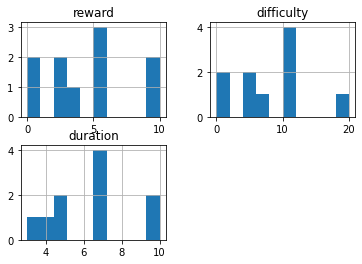

In [7]:
portfolio.hist()


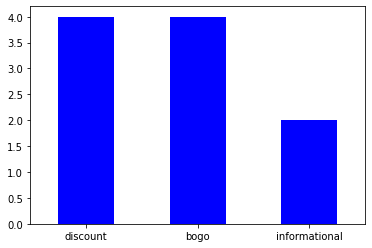

In [8]:
# Offer types distribution
portfolio['offer_type'].value_counts().plot(kind='bar', color='b', rot=0);

As we can see that the data in portfolio does not have any null value, the categorical features of the data is correct and there do not exist any type error. The only job we need to fix in order to make the data clean is to One-hot encode the categorical feature of the data (channels, offer_type)

##### profile.json

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

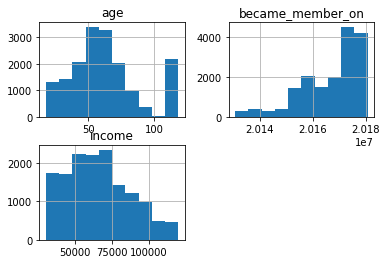

In [13]:
profile.hist()

As we can see, there exist null value in gender and income features, therefore we have to handle the missing value in the data cleaning process. Also, the max age number is 118 which is quite non-sense, thus, all age above 100 should be change to Nan. We also need to transform the date time format of became_member_on feature and also encoded the gender collumns.  

##### transcript.json

In [14]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [15]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [16]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

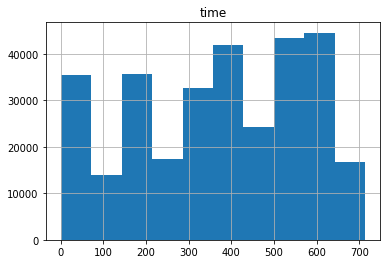

In [17]:
transcript.hist()

In [18]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Regard to the data from transcript.json, we have to split the value col to offer_id and amount. Also, splitting event col based on offer and transaction. Finally, we have to drop the the customer id value that don't exist in the profile.json.

## Data cleaning

In [19]:
def id_mapper(df):
    '''
    Mapper function to map unique integer ids to customers and offers

    INPUT:
    df - a dataframe holding the 'id' variable

    OUTPUT:
    coded_dict - a dictionary with original and encoded id values
    '''
    coded_dict = dict()
    counter = 1

    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter += 1

    return coded_dict


In [20]:
def cleanPortfolio(portfolio):
    '''
    Function to clean the portfolio data
    
    INPUT:
    portfolio - a dataframe read from portfolio.json

    OUTPUT:
    portfolio_new - a data frame of portfolio which is cleaned
    offer_id_encoded - encoded map of the offer_id
    '''
    
    mlb = MultiLabelBinarizer()
    portfolio_new = portfolio.copy()
    # Nomorlize the id of the offer
    offer_id_encoded = id_mapper(portfolio_new)
    portfolio_new['offer id'] = portfolio_new['id'].map(offer_id_encoded)
    
    # Split channel to different collums
    portfolio_new = pd.concat([portfolio_new, 
                              pd.DataFrame(mlb.fit_transform(portfolio_new['channels']),columns=mlb.classes_, index=portfolio_new.index)],
                              axis=1, sort=False
                             )

    # One-hot encode 'offer_type'
    portfolio_new = pd.get_dummies(portfolio_new, columns = ['offer_type'])
    # drop uneccessary collumns
    portfolio_new = portfolio_new.drop(['id', 'channels'], axis=1)


    return portfolio_new, offer_id_encoded

portfolio_new, offer_id_encoded = cleanPortfolio(portfolio)
portfolio_new

,reward,difficulty,duration,offer id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,1,1,1,1,0,1,0,0
1,10,10,5,2,1,1,1,1,1,0,0
2,0,0,4,3,1,1,0,1,0,0,1
3,5,5,7,4,1,1,0,1,1,0,0
4,5,20,10,5,1,0,0,1,0,1,0
5,3,7,7,6,1,1,1,1,0,1,0
6,2,10,10,7,1,1,1,1,0,1,0
7,0,0,3,8,1,1,1,0,0,0,1
8,5,5,5,9,1,1,1,1,1,0,0
9,2,10,7,10,1,1,0,1,0,1,0


In [21]:
portfolio_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   reward                    10 non-null     int64
 1   difficulty                10 non-null     int64
 2   duration                  10 non-null     int64
 3   offer id                  10 non-null     int64
 4   email                     10 non-null     int64
 5   mobile                    10 non-null     int64
 6   social                    10 non-null     int64
 7   web                       10 non-null     int64
 8   offer_type_bogo           10 non-null     uint8
 9   offer_type_discount       10 non-null     uint8
 10  offer_type_informational  10 non-null     uint8
dtypes: int64(8), uint8(3)
memory usage: 798.0 bytes


As we can see, the data is represent as we expected, offer id is normalized to integer. The categotical collumns `channel` and `offer_type` is one hot encoded. 

In [22]:
def cleanProfile(profile):
    '''
    Function to clean the profile data
    
    INPUT:
    profile - a dataframe read from profile.json

    OUTPUT:
    profile_new - a data frame of portfolio which is cleaned
    cust_id_encoded - encoded map of the customer_id
    '''
    profile_new = profile.copy()

    # Drop collumn with missing gender and age
    profile_new = profile_new.dropna()
    
    cust_id_encoded = id_mapper(profile_new)
    profile_new['customer_id'] = profile_new['id'].map(cust_id_encoded)
    profile_new = profile_new.drop('id', axis=1)
    
    # Format date in became_member_on
    profile_new['became_member_on'] = profile_new['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    profile_new['membership_duration'] = profile_new.became_member_on.max() - \
        profile_new['became_member_on']
    profile_new['membership_duration'] = profile_new['membership_duration'].apply(
        lambda x: x.days if x is not np.nan else x)

    # One hot encoded gender
    profile_new = pd.get_dummies(profile_new, columns = ['gender'])
    # change the age number over 100 to NaN value
    profile_new.loc[profile_new['age'] > 100, 'age'] = np.nan
        
    return profile_new, cust_id_encoded

profile_new, cust_id_encoded = cleanProfile(profile)
profile_new

,age,became_member_on,income,customer_id,membership_duration,gender_F,gender_M,gender_O
1,55.0,2017-07-15,112000.0,1,376,1,0,0
3,75.0,2017-05-09,100000.0,2,443,1,0,0
5,68.0,2018-04-26,70000.0,3,91,0,1,0
8,65.0,2018-02-09,53000.0,4,167,0,1,0
12,58.0,2017-11-11,51000.0,5,257,0,1,0
...,...,...,...,...,...,...,...,...
16995,45.0,2018-06-04,54000.0,14821,52,1,0,0
16996,61.0,2018-07-13,72000.0,14822,13,0,1,0
16997,49.0,2017-01-26,73000.0,14823,546,0,1,0
16998,83.0,2016-03-07,50000.0,14824,871,1,0,0


In [23]:
profile_new.describe()

,age,income,customer_id,membership_duration,gender_F,gender_M,gender_O
count,14820.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.377800,65404.991568,7413.000000,522.478988,0.413423,0.572277,0.014300
std,17.365541,21598.299410,4279.753206,419.205158,0.492464,0.494765,0.118729
min,18.000000,30000.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,3707.000000,208.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,7413.000000,358.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,11119.000000,797.000000,1.000000,1.000000,0.000000
max,100.000000,120000.000000,14825.000000,1823.000000,1.000000,1.000000,1.000000


In [24]:
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   age                  14820 non-null  float64       
 1   became_member_on     14825 non-null  datetime64[ns]
 2   income               14825 non-null  float64       
 3   customer_id          14825 non-null  int64         
 4   membership_duration  14825 non-null  int64         
 5   gender_F             14825 non-null  uint8         
 6   gender_M             14825 non-null  uint8         
 7   gender_O             14825 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), int64(2), uint8(3)
memory usage: 738.4 KB


In [25]:
def cleanTranscript(transcript, offer_id_encoded, cust_id_encoded):
    '''
    Function to clean the transcript data
    
    INPUT:
    transcript - a dataframe read from transcript.json
    cust_id_encoded - encoded map of the customer_id
    offer_id_encoded - encoded map of the offer_id

    OUTPUT:
    transcript_new - a data frame of transcript which is cleaned
    '''
    transcript_new = transcript.copy()
    
    # map customer id 
    transcript_new['customer_id'] = transcript_new['person'].map(cust_id_encoded)
    
    # sort data
    transcript_new = transcript_new.set_index(['customer_id', 'time']).sort_values(by=['customer_id', 'time']).reset_index()
    
    # split 'value' collumn
    transcript_new = pd.concat([transcript_new.drop(['value'], axis=1), transcript_new['value'].apply(pd.Series)], axis=1)
    
    # fill Na value
    transcript_new['amount'] = transcript_new['amount'].fillna(0)
    transcript_new['reward'] = transcript_new['reward'].fillna(0)
    
    # split 'event' collumn
    transcript_new = pd.get_dummies(transcript_new, columns = ['event'])
    
    # Move the non NaN values in 'offer_id' to 'offer id'
    transcript_new['offer id'] = transcript_new['offer id'].fillna(transcript_new['offer_id'])
    transcript_new = transcript_new.drop(columns='offer_id', axis=1)
    
    # map the offer id to the mapped value
    transcript_new['offer id'] = transcript_new['offer id'].map(offer_id_encoded)
    
    transcript_new = transcript_new.drop('person', axis=1)

    # Change the time from hours to days
    transcript_new['time'] = transcript_new['time'] / 24
        
    return transcript_new

transcript_new = cleanTranscript(transcript, offer_id_encoded, cust_id_encoded)
transcript_new

,customer_id,time,amount,offer id,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,1.0,0.75,21.51,NaN,0.0,0,0,0,1
1,1.0,6.00,32.28,NaN,0.0,0,0,0,1
2,1.0,17.00,0.00,4.0,0.0,0,1,0,0
3,1.0,21.00,0.00,3.0,0.0,0,1,0,0
4,1.0,22.00,23.22,NaN,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
306529,NaN,29.75,0.00,6.0,3.0,1,0,0,0
306530,NaN,29.75,4.48,NaN,0.0,0,0,0,1
306531,NaN,29.75,0.00,7.0,2.0,1,0,0,0
306532,NaN,29.75,2.20,NaN,0.0,0,0,0,1


In [26]:
transcript_new.describe()

,customer_id,time,amount,offer id,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
count,272762.000000,306534.000000,306534.000000,167581.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,7413.116911,15.265956,5.792023,5.550522,0.537219,0.109544,0.248837,0.188315,0.453304
std,4277.677254,8.346930,21.337137,2.885785,1.805208,0.312321,0.432340,0.390964,0.497815
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3713.000000,7.750000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7410.000000,17.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11110.000000,22.000000,7.100000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,14825.000000,29.750000,1062.280000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            272762 non-null  float64
 1   time                   306534 non-null  float64
 2   amount                 306534 non-null  float64
 3   offer id               167581 non-null  float64
 4   reward                 306534 non-null  float64
 5   event_offer completed  306534 non-null  uint8  
 6   event_offer received   306534 non-null  uint8  
 7   event_offer viewed     306534 non-null  uint8  
 8   event_transaction      306534 non-null  uint8  
dtypes: float64(5), uint8(4)
memory usage: 12.9 MB


### Merge data

In [28]:
# Merge 'portfolio' fields into 'transcript' data frame
transcript_new = transcript_new.merge(portfolio_new, on='offer id', how='left')
# Rename columns

transcript_new.rename(columns={'reward_x': 'amount_rewarded',
                               'reward_y': 'offer_reward',
                               'email': 'channel_email',
                               'mobile': 'channel_mobile',
                               'social': 'channel_social',
                               'web': 'channel_web'}, inplace=True)
transcript_new.head()

,customer_id,time,amount,offer id,amount_rewarded,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,1.0,0.75,21.51,NaN,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,6.00,32.28,NaN,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,17.00,0.00,4.0,0.0,0,1,0,0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1.0,21.00,0.00,3.0,0.0,0,1,0,0,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,22.00,23.22,NaN,0.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               272762 non-null  float64
 1   time                      306534 non-null  float64
 2   amount                    306534 non-null  float64
 3   offer id                  167581 non-null  float64
 4   amount_rewarded           306534 non-null  float64
 5   event_offer completed     306534 non-null  uint8  
 6   event_offer received      306534 non-null  uint8  
 7   event_offer viewed        306534 non-null  uint8  
 8   event_transaction         306534 non-null  uint8  
 9   offer_reward              167581 non-null  float64
 10  difficulty                167581 non-null  float64
 11  duration                  167581 non-null  float64
 12  channel_email             167581 non-null  float64
 13  channel_mobile            167581 non-null  f

In [30]:
# Merge 'profile' fields into 'transcript' data frame

transcript_new = transcript_new.merge(profile_new, on='customer_id', how='left')

In [31]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_id               272762 non-null  float64       
 1   time                      306534 non-null  float64       
 2   amount                    306534 non-null  float64       
 3   offer id                  167581 non-null  float64       
 4   amount_rewarded           306534 non-null  float64       
 5   event_offer completed     306534 non-null  uint8         
 6   event_offer received      306534 non-null  uint8         
 7   event_offer viewed        306534 non-null  uint8         
 8   event_transaction         306534 non-null  uint8         
 9   offer_reward              167581 non-null  float64       
 10  difficulty                167581 non-null  float64       
 11  duration                  167581 non-null  float64       
 12  ch

In [32]:
transcript_new.head()

,customer_id,time,amount,offer id,amount_rewarded,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_reward,...,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,membership_duration,gender_F,gender_M,gender_O
0,1.0,0.75,21.51,NaN,0.0,0,0,0,1,NaN,...,NaN,NaN,NaN,55.0,2017-07-15,112000.0,376.0,1.0,0.0,0.0
1,1.0,6.00,32.28,NaN,0.0,0,0,0,1,NaN,...,NaN,NaN,NaN,55.0,2017-07-15,112000.0,376.0,1.0,0.0,0.0
2,1.0,17.00,0.00,4.0,0.0,0,1,0,0,5.0,...,1.0,0.0,0.0,55.0,2017-07-15,112000.0,376.0,1.0,0.0,0.0
3,1.0,21.00,0.00,3.0,0.0,0,1,0,0,0.0,...,0.0,0.0,1.0,55.0,2017-07-15,112000.0,376.0,1.0,0.0,0.0
4,1.0,22.00,23.22,NaN,0.0,0,0,0,1,NaN,...,NaN,NaN,NaN,55.0,2017-07-15,112000.0,376.0,1.0,0.0,0.0


The `transcripts_new` is the cleaned data which is merged from 3 original files. Next we will perform some data analysis from this data set

## Data Exploration

In [33]:
# TODO: Start to EDA with df data frame
df = transcript_new.copy()
df.head()
# Export the data to csv for later use
df.to_csv("data/cleanData.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_id               272762 non-null  float64       
 1   time                      306534 non-null  float64       
 2   amount                    306534 non-null  float64       
 3   offer id                  167581 non-null  float64       
 4   amount_rewarded           306534 non-null  float64       
 5   event_offer completed     306534 non-null  uint8         
 6   event_offer received      306534 non-null  uint8         
 7   event_offer viewed        306534 non-null  uint8         
 8   event_transaction         306534 non-null  uint8         
 9   offer_reward              167581 non-null  float64       
 10  difficulty                167581 non-null  float64       
 11  duration                  167581 non-null  float64       
 12  ch

In [35]:
df.describe()

,customer_id,time,amount,offer id,amount_rewarded,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_reward,...,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,membership_duration,gender_F,gender_M,gender_O
count,272762.000000,306534.000000,306534.000000,167581.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,167581.00000,...,167581.000000,167581.000000,167581.000000,167581.000000,272664.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000
mean,7413.116911,15.265956,5.792023,5.550522,0.537219,0.109544,0.248837,0.188315,0.453304,4.41991,...,0.806858,0.427358,0.417100,0.155543,53.823746,64337.000755,581.291950,0.414651,0.570791,0.014558
std,4277.677254,8.346930,21.337137,2.885785,1.805208,0.312321,0.432340,0.390964,0.497815,3.37336,...,0.394765,0.494696,0.493081,0.362422,17.531700,21243.762941,428.810204,0.492663,0.494964,0.119777
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,3713.000000,7.750000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,...,1.000000,0.000000,0.000000,0.000000,41.000000,48000.000000,242.000000,0.000000,0.000000,0.000000
50%,7410.000000,17.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.00000,...,1.000000,0.000000,0.000000,0.000000,55.000000,62000.000000,471.000000,0.000000,1.000000,0.000000
75%,11110.000000,22.000000,7.100000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.00000,...,1.000000,1.000000,1.000000,0.000000,66.000000,78000.000000,862.000000,1.000000,1.000000,0.000000
max,14825.000000,29.750000,1062.280000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,10.00000,...,1.000000,1.000000,1.000000,1.000000,100.000000,120000.000000,1823.000000,1.000000,1.000000,1.000000


<h4>Spending trend(age) by offered type of coupon & channel</h4>


1. we can say that most of the members get their cupons through the email and mobile. However, number of the members who got noctice via email is slightly higher then the members who got notification through the mobile.

2. Members in early 20s,early 30 get buy one get one coupons.

3. Starbucks is not promoting enough coupons by informational offer.

4. Only half of the coupons leads to actual use.


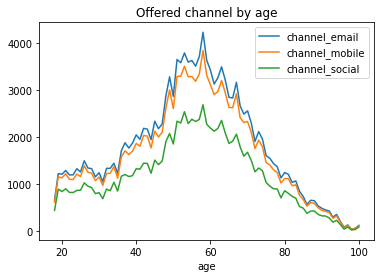

In [36]:
spending_trend_age_channel = df[['age','channel_email','channel_mobile','channel_social']].groupby('age', as_index=False).sum()
spending_trend_age_channel.plot(x="age",title="Offered channel by age")
plt.legend(facecolor='white', fontsize=10)

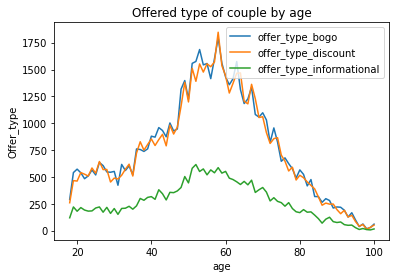

In [37]:
spending_trend_age = df[['age','offer_type_bogo','offer_type_discount','offer_type_informational']].groupby('age', as_index=False).sum()
spending_trend_age.plot(x="age",title="Offered type of couple by age")
plt.ylabel('Offer_type',fontsize=10)
plt.legend(facecolor='white', fontsize=10)

<AxesSubplot:title={'center':'Number of members perticipates in the event'}, xlabel='age'>

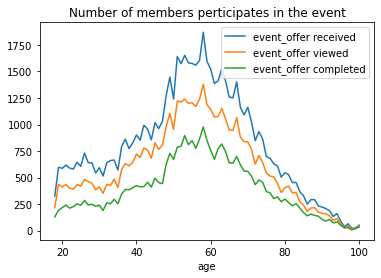

In [38]:
received = df[['age','event_offer received','event_offer viewed','event_offer completed']].groupby('age', as_index=False).sum()
received.plot(x="age",title="Number of members perticipates in the event")

<h4>Finding out which year and month have joined to become a member</h4>  


1. we can say that December and January gained almost double amount of member from 2013 - 2018.  

2. Starbucks is getting more and more member through the year  

3. Regard that this dataset is realised in the middle of 2018, we can assume that Starbucsk will get more new members in end of 2018.  

4. Nevertheless, the number of new members started to decrease from 2016.  

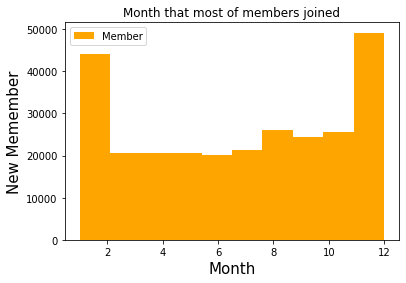

In [39]:
#using lambda function to sort the 'become_member_on' into month and year
plt.clf()
df['became_member_on'].map(lambda d: d.month).plot(kind='hist',color='orange',title='Month that most of members joined',label="Member")
plt.xlabel('Month',fontsize=15)
plt.ylabel('New Memember',fontsize=15)
plt.legend(facecolor='white', fontsize=10)
plt.show()


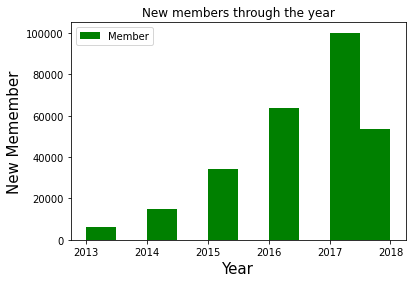

In [40]:
plt.clf()
df['became_member_on'].map(lambda d: d.year).plot(kind='hist',color='g',title='New members through the year',label="Member")
plt.xlabel('Year',fontsize=15)
plt.ylabel('New Memember',fontsize=15)
plt.legend(facecolor='white', fontsize=10)
plt.show()


## Data modelling

### Problem in data set

Based on the descriptive analysis of the datasets, our goal for this project is to predict is the offer sent to each customer is effective or not. Before moving in to detail process, the first thing we should do is to understand the convention of offer's events and have a definition of what is an effective offer.

First and foremost, about the offer process, the customer first recieved the offer and the offer status is now set to `offer_recieved`. If the user click to view it, the status is set to `offer_viewed`. The next level of event is based on the offer types, if it is BOGO or discount offer, the event is set to `offer_completed`, then the `transaction`, while the informational offer event is set `transaction`. In general the life cycle of an offer event is represented as follow:

* For BOGO and discount:
    * `offer_recieved` ---> `offer_viewed` ---> `offer_completed` ---> `transaction`
* For informational offer:
    * `offer_recieved` ---> `offer_viewed` ---> `transaction`

In this project, we assume that an offer is considered **success** if the offer status is viewed. Because when the offer is viewed by the customer, it will make an influenced to the customer, therefore the conversion rate will increased.

### Feature Engineering

Before trainning model, we have to transform the data and select appropriate features and target to train the model. 

In [41]:
# check null
df.isnull().sum()

customer_id                  33772
time                             0
amount                           0
offer id                    138953
amount_rewarded                  0
event_offer completed            0
event_offer received             0
event_offer viewed               0
event_transaction                0
offer_reward                138953
difficulty                  138953
duration                    138953
channel_email               138953
channel_mobile              138953
channel_social              138953
channel_web                 138953
offer_type_bogo             138953
offer_type_discount         138953
offer_type_informational    138953
age                          33870
became_member_on             33772
income                       33772
membership_duration          33772
gender_F                     33772
gender_M                     33772
gender_O                     33772
dtype: int64

As we can see, after merge three data set into one, there exist many NaN value in the data set. The first thing we have to do is to handle all NaN value exist in the data set. We can see that all of the attributes related to the customer and offer is null. Since we only care about the transcrpts with offer and customer infomation. Hence, we can drop all the rows without offer id and age.

In [42]:
# remove null value
new_df = df.dropna(subset=['offer id'])
new_df = new_df.dropna(subset=['age'])
new_df.isnull().sum()

customer_id                 0
time                        0
amount                      0
offer id                    0
amount_rewarded             0
event_offer completed       0
event_offer received        0
event_offer viewed          0
event_transaction           0
offer_reward                0
difficulty                  0
duration                    0
channel_email               0
channel_mobile              0
channel_social              0
channel_web                 0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
age                         0
became_member_on            0
income                      0
membership_duration         0
gender_F                    0
gender_M                    0
gender_O                    0
dtype: int64

Next, we have to drop duplicate row exist in the data.

In [43]:
new_df = new_df.drop('became_member_on', axis=1)

# drop duplicate rows
new_df.drop_duplicates()


,customer_id,time,amount,offer id,amount_rewarded,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_reward,...,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,membership_duration,gender_F,gender_M,gender_O
2,1.0,17.00,0.0,4.0,0.0,0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,55.0,112000.0,376.0,1.0,0.0,0.0
3,1.0,21.00,0.0,3.0,0.0,0,1,0,0,0.0,...,1.0,0.0,0.0,1.0,55.0,112000.0,376.0,1.0,0.0,0.0
5,1.0,22.00,0.0,4.0,5.0,1,0,0,0,5.0,...,1.0,1.0,0.0,0.0,55.0,112000.0,376.0,1.0,0.0,0.0
6,2.0,0.00,0.0,4.0,0.0,0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,75.0,100000.0,443.0,1.0,0.0,0.0
7,2.0,0.25,0.0,4.0,0.0,0,0,1,0,5.0,...,1.0,1.0,0.0,0.0,75.0,100000.0,443.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272754,14825.0,14.00,0.0,3.0,0.0,0,1,0,0,0.0,...,1.0,0.0,0.0,1.0,62.0,82000.0,369.0,1.0,0.0,0.0
272755,14825.0,17.00,0.0,9.0,0.0,0,1,0,0,5.0,...,1.0,1.0,0.0,0.0,62.0,82000.0,369.0,1.0,0.0,0.0
272757,14825.0,20.00,0.0,9.0,5.0,1,0,0,0,5.0,...,1.0,1.0,0.0,0.0,62.0,82000.0,369.0,1.0,0.0,0.0
272759,14825.0,22.75,0.0,9.0,0.0,0,0,1,0,5.0,...,1.0,1.0,0.0,0.0,62.0,82000.0,369.0,1.0,0.0,0.0


From the target feature, as stated at the beginning of the assignment: **All of the offer which is viewed, completed is considered an success offer**. Hence, we have to create a binary collumns `offer_succeed` from event_offers cols. 

In [44]:
# make new collumns which is the target for train model.
for i, item in new_df.iterrows():
    offer_succeed = 0
    if item['event_offer completed'] == 1 or item['event_offer viewed'] == 1:
        offer_succeed = 1
    else:
        offer_succeed = 0
    new_df.loc[i, 'offer_succeed'] = offer_succeed
new_df['offer_succeed'].value_counts()


1.0    82276
0.0    66478
Name: offer_succeed, dtype: int64

After modifying the data, we can see that there are 25 collumns with the same amount of rows and fully converted to number type attributes.

In [45]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148754 entries, 2 to 272760
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               148754 non-null  float64
 1   time                      148754 non-null  float64
 2   amount                    148754 non-null  float64
 3   offer id                  148754 non-null  float64
 4   amount_rewarded           148754 non-null  float64
 5   event_offer completed     148754 non-null  uint8  
 6   event_offer received      148754 non-null  uint8  
 7   event_offer viewed        148754 non-null  uint8  
 8   event_transaction         148754 non-null  uint8  
 9   offer_reward              148754 non-null  float64
 10  difficulty                148754 non-null  float64
 11  duration                  148754 non-null  float64
 12  channel_email             148754 non-null  float64
 13  channel_mobile            148754 non-null  f

In [46]:
new_df.describe()

,customer_id,time,amount,offer id,amount_rewarded,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_reward,...,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,membership_duration,gender_F,gender_M,gender_O,offer_succeed
count,148754.000000,148754.000000,148754.0,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000,148754.0,148754.000000,...,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000,148754.000000
mean,7409.058459,14.773532,0.0,5.545545,1.079010,0.218024,0.446899,0.335077,0.0,4.443181,...,0.429084,0.418664,0.152251,54.763435,66413.346868,538.152984,0.428009,0.557269,0.014722,0.553101
std,4277.323910,8.262825,0.0,2.888229,2.452825,0.412905,0.497174,0.472019,0.0,3.372552,...,0.494947,0.493342,0.359266,17.175163,21497.147774,415.366670,0.494792,0.496711,0.120439,0.497174
min,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3707.000000,7.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,...,0.000000,0.000000,0.000000,43.000000,51000.000000,221.000000,0.000000,0.000000,0.000000,0.000000
50%,7401.000000,17.000000,0.0,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.000000,...,0.000000,0.000000,0.000000,56.000000,65000.000000,394.000000,0.000000,1.000000,0.000000,1.000000
75%,11110.000000,21.250000,0.0,8.000000,0.000000,0.000000,1.000000,1.000000,0.0,5.000000,...,1.000000,1.000000,0.000000,67.000000,81000.000000,816.000000,1.000000,1.000000,0.000000,1.000000
max,14825.000000,29.750000,0.0,10.000000,10.000000,1.000000,1.000000,1.000000,0.0,10.000000,...,1.000000,1.000000,1.000000,100.000000,120000.000000,1823.000000,1.000000,1.000000,1.000000,1.000000


Now we select the list of features that we need to train the model with.

In [47]:
# select features
X = new_df.drop(['customer_id', 'amount', 'event_offer completed', 'event_offer received', 
                 'event_offer viewed', 'event_transaction', 'offer_succeed'], axis=1)
X
# Export the data to csv for later use
X.to_csv("data/features.csv")

In [48]:
# select target
Y = new_df['offer_succeed']
Y
# Export the data to csv for later use
Y.to_csv("data/target.csv")

In [74]:
Y

2         0.0
3         0.0
5         1.0
6         0.0
7         1.0
         ... 
272754    0.0
272755    0.0
272757    1.0
272759    1.0
272760    0.0
Name: offer_succeed, Length: 148754, dtype: float64

Now the data is capable for trainning model with selected features and target. In the next part, we will start to train the the data in different models to find the best model for the data set. 

### Train Modelling and parameter tunning

As stated from the beginning, we have to build a binary classification model to predict whether the offer is effective or not. Our team has selected four models to our project. the first two model are quite basic one which are `logistic regression` and `random forest`. The others, `AdaBoostClassifier` adn `LGBMClassifier`, are more advance one which is considered more effective.

In [49]:
# Modeling
from sklearn.metrics import classification_report, f1_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Export model
import pickle

#List to store the model point
model_score = []


In [50]:
# split the data into different data set for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [51]:
def evaluate_model_performance(clf, X_train, y_train):
    '''evaluate a model's accuracy and F1-score
    INPUT:
    clf - Model object
    X_train - Training data matrix
    y_train - Expected model output vector
    OUTPUT:
    clf_accuracy: Model accuracy
    clf_f1_score: Model F1-score
    '''
    class_name = str(clf.__class__)
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    
    y_pred_rf = clf.predict(X_train)
    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))

    return clf_accuracy, clf_f1_score

#### LogisticRegression

The `logistic regression` will construct a linear decision boundary to decide effective and non-effective offer. In this part we will use `logistic regression` method and perform parameter tunning with GridSearchCV to fit the train data set to the model.

In [52]:
%%time

model =  LogisticRegression()

parameters = {
    'C': [ 1, 10, 20, 30],
    'max_iter': [1000, 4000, 10000]
}

log_reg = GridSearchCV(model, parameters, refit=True)
log_reg.fit(X_train, y_train)

print('Best Score: ', log_reg.best_score_*100, '\nBest Parameters: ', log_reg.best_params_)

Best Score:  63.888261668265464 
Best Parameters:  {'C': 10, 'max_iter': 1000}
CPU times: user 11min 32s, sys: 6min 23s, total: 17min 56s
Wall time: 2min 32s


The `C` value is Inverse of regularization strength, smaller value denote stronger regularization, the `C` value that is best fit for this model is 1. Also, the maxinum iteration that the model need to fit the trainning data is 1000. 

In [53]:
acc, f1 = evaluate_model_performance(log_reg,  X_test, y_test)
model_score.append(['LogisticRegression', acc, f1])

GridSearchCV'> model accuracy: 0.662
GridSearchCV'> model f1-score: 0.643


As we can see, the model accuracy and f1 score is around 0.65 which is not a high point and the model is not reliable for this project

In [54]:
with open("model/logRegression_model.pkl", 'wb') as file:
    pickle.dump(log_reg, file)

#### RandomForestClassifier

The `RandomForestClassifier` ues several decision tree and train each tree individually with a random fraction of the data. We will also perform parameter tunning in `max_feature` an `n_estimator` parameter and fit the model with trainning data.

In [55]:
%%time

model =  RandomForestClassifier()

parameters = {
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [10, 100, 1000]
}

rf_clf= GridSearchCV(model, parameters, refit=True)
rf_clf.fit(X_train, y_train)

print('Best Score: ', rf_clf.best_score_*100, '\nBest Parameters: ', rf_clf.best_params_)

Best Score:  78.42407942043252 
Best Parameters:  {'max_features': 'sqrt', 'n_estimators': 1000}
CPU times: user 19min 45s, sys: 8.19 s, total: 19min 54s
Wall time: 19min 55s


In [56]:
acc, f1 = evaluate_model_performance(rf_clf,  X_test, y_test)
model_score.append(['RandomForestClassifier', acc, f1])

GridSearchCV'> model accuracy: 0.774
GridSearchCV'> model f1-score: 0.790


The model score is much better than the previous `logistic regession`. It is a decent model for this project.

In [57]:
# The model is too heavy so we dont export it to the file in order to reduce file size
# with open("model/randomForestClf_model.pkl", 'wb') as file:
#     pickle.dump(rf_clf, file)

#### AdaBoostClassifier

The `AdaBoostClassifier` is a combination of multiple classifiers in order to achieve higher accuracy score. The methodoly of `AdaboostClassifier` is to set the weight of the classifier and trainning it iteratively. The most important parameter of AdaBoostClassifier is `n_estimators` - number of weak learner and `learning_rate` - weight of weak learner. We will use GridSearchCV to perform parameter tunning is these parameters and evaluate the model performance

In [58]:
%%time

model = AdaBoostClassifier()

parameters = {
    'learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 1.0],
    'n_estimators': [10, 50, 100, 200]
}

ada_clf = GridSearchCV(model, parameters, refit=True)
ada_clf.fit(X_train, y_train)

print('Best Score: ', ada_clf.best_score_*100, '\nBest Parameters: ', ada_clf.best_params_)

Best Score:  92.68253872533427 
Best Parameters:  {'learning_rate': 1.0, 'n_estimators': 100}
CPU times: user 11min 20s, sys: 234 ms, total: 11min 21s
Wall time: 11min 22s


In [59]:
acc, f1 = evaluate_model_performance(ada_clf, X_test, y_test)
model_score.append(['AdaBoostClassifier', acc, f1])

GridSearchCV'> model accuracy: 0.927
GridSearchCV'> model f1-score: 0.930


From the score of the model, we could say it is the best model until now with a high accuracy and f1 score. But it take quit a long time to train.

In [60]:
with open("model/adaClf_model.pkl", 'wb') as file:
    pickle.dump(ada_clf, file)

#### LGBMClassifier

`LGBMClassifier` is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient as compared to other boosting algorithms. We will train the model to fit with our trainning data.

In [61]:
%%time

model =  LGBMClassifier()

parameters = {
    'num_leaves': [6,18,36,52], 
    'boosting_type' : ['gbdt', 'dart'],
    'max_depth ': [5,10,15, None],
    'min_data_in_leaf': [20, 30, 50, 100]
}

lgbm_clf= GridSearchCV(model, parameters, verbose=2, cv=5, n_jobs=-1)
lgbm_clf.fit(X_train, y_train)

print('Best Score: ', lgbm_clf.best_score_*100, '\nBest Parameters: ', lgbm_clf.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  5.6min finished


[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Best Score:  92.68253872533427 
Best Parameters:  {'boosting_type': 'gbdt', 'max_depth ': 5, 'min_data_in_leaf': 20, 'num_leaves': 6}
CPU times: user 7.88 s, sys: 6.86 s, total: 14.7 s
Wall time: 5min 35s


In [62]:
acc, f1 = evaluate_model_performance(lgbm_clf,  X_test, y_test)
model_score.append(['LGBMClassifier', acc, f1])

GridSearchCV'> model accuracy: 0.927
GridSearchCV'> model f1-score: 0.930


The model have the same score as `AdaBoostClasifier`, however, the time need to train the model is much lower than `AdaBoostClasifier`. Therefore, the `LGBMClassifier` is the more effective.

In [63]:
with open("model/lgbmClf_model.pkl", 'wb') as file:
    pickle.dump(lgbm_clf, file)

### Model Evaluation

In [64]:
# Display the score of model with test data set
scores = pd.DataFrame(model_score, columns =['Model', 'Accuracy Score', 'F1 Score'])
scores

,Model,Accuracy Score,F1 Score
0,LogisticRegression,0.662230,0.643438
1,RandomForestClassifier,0.774024,0.790005
2,AdaBoostClassifier,0.927364,0.929598
3,LGBMClassifier,0.927364,0.929598


As we can see in the table, the AdaboostClassifier and LGBM have classifier have the same accuracy and f1-score. However, the LGBMClassifier takes shorter time to train, hence, we can conclude that the best model is the LGBM classifier.

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
     INPUT:
    y_train_true: True binary labels of 0 or 1 in the training dataset
    y_train_prob: Probability in range {0,1} predicted by the model for the training dataset
    y_test_true: True binary labels of 0 or 1 in the testing dataset
    y_test_prob: Probability in range {0,1} predicted by the model for the testing dataset
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label =True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print ('Train Accuracy: %s ' %acc_train)
    print ('Train AUC: %s ' %auc_train)
    print ('Train Confusion Matrix:')
    print (cm_train)

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print ('Test Accuracy: %s ' %acc_test)
    print ('Test AUC: %s ' %auc_test)
    print ('Test Confusion Matrix:')
    print (cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

Train Accuracy: 0.9265480702167173 
Train AUC: 0.9336274450249058 
Train Confusion Matrix:
[[53155     0]
 [ 8741 57107]]
Test Accuracy: 0.9271621121979093 
Test AUC: 0.934045532018505 
Test Confusion Matrix:
[[13323     0]
 [ 2167 14261]]


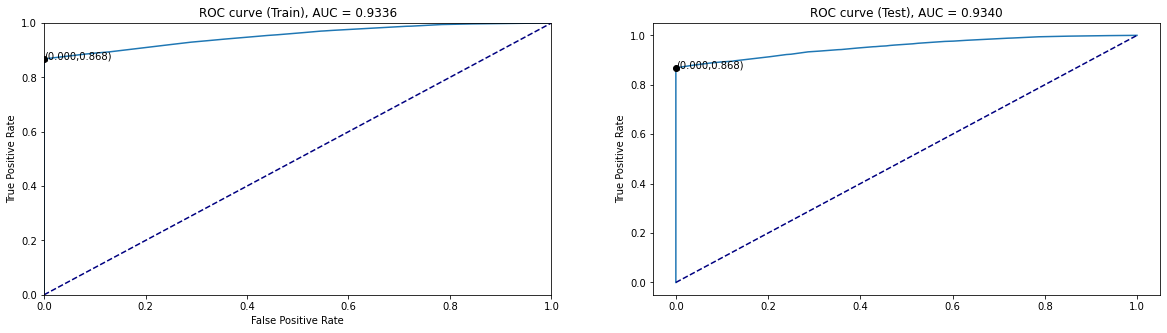

0.7762147118654299

In [66]:
y_test_pred_proba = lgbm_clf.predict_proba(X_test)[::,1]
y_train_pred_proba = lgbm_clf.predict_proba(X_train)[::,1]
plot_ROC(y_train, y_train_pred_proba, y_test, y_test_pred_proba)

### Predict the succes rate of offer type

In [67]:
pkl_filename = "model/lgbmClf_model.pkl"
# Load from file
with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

In [68]:
def predict_offer_success(customer_id, offer_id, clf_model, time=0, amount_reward=0.0):
    """
    This function using model to predict whether the offer type apply to this type of customer is effective or not
    """
    # create customer profile
    customer_profile = new_df.drop(['offer_reward', 'difficulty', 'duration', 'offer id', 'channel_email', 
                                    'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo', 
                                    'offer_type_discount', 'offer_type_informational',  'amount', 
                                    'event_offer completed', 'event_offer received', 'event_offer viewed',
                                    'event_transaction', 'offer_succeed', 'time', 'amount_rewarded'], axis=1)

    customer_profile = customer_profile.drop_duplicates()
    # Create offer profile
    offers = portfolio_new.copy()
    offers.rename(columns={'reward': 'offer_reward',
                       'email': 'channel_email',
                       'mobile': 'channel_mobile',
                       'social': 'channel_social',
                       'web': 'channel_web'}, inplace=True)
    
    offer = offers[offers['offer id'] == offer_id].reset_index()
    cust = customer_profile[customer_profile['customer_id'] == customer_id].reset_index()
    
    # make featres
    feature = pd.concat([cust, offer], axis=1)
    feature.drop(["customer_id"], axis=1)
    feature['time'] = time
    feature['amount_rewarded'] = amount_reward

    # predict
    list_features = ['time', 'offer id', 'offer_reward', 'difficulty', 'duration', 'channel_email', 
                     'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo', 
                     'offer_type_discount', 'offer_type_informational', 'age', 'income', 
                     'membership_duration', 'gender_F', 'gender_M', 'gender_O', 'amount_rewarded']
    success = clf_model.predict(feature[list_features])
    if success[0] == 0:
        print('offer is not effective')
    else:
        print("offer is effective")
    return success

In [69]:
for offer_id in range(10):
    print("Offer id: ", offer_id)
    predict_offer_success(1413, offer_id, clf)

Offer id:  0
offer is not effective
Offer id:  1
offer is effective
Offer id:  2
offer is effective
Offer id:  3
offer is not effective
Offer id:  4
offer is effective
Offer id:  5
offer is effective
Offer id:  6
offer is effective
Offer id:  7
offer is effective
Offer id:  8
offer is not effective
Offer id:  9
offer is effective


## Conclusion

In conclusion, from the data of customer behavior of Starbucks application, we have applied the process of data science to draw the some insights and build an predictitve model to evaluate the effectiveness of an offer base on the customer profile. The first part of this process is data cleanning which is one of the most chalenging part in this project, because the raw data is in JSON type with dictionary structure. Thus a tremedous amount of work has to done when dealing with data such as one hot ecoding categorical features, drop null value, merge the data sets. After finished cleaning, in the EDA part we have analyzed the data to aquire some insights about the customer spending trend with different offer type and customer membership duration over time. Finally, we have performed parameter tunning with 4 differents binary classification models and found out that the LightGBMClassifier is the most effitive model with the accuracy and f1 score over 0.9. In the future, some improvement can be done with this project. From the information, we can make more features to increase the accuracy of the model, other high performance models such as XGBoost or CatBoost could be taken into account and the project can be taken to a further step which is to predict the best offer type for a specific customer.  